Loading data...
Loaded data with shape: (6040, 214)
Loading metadata...
Added SN type information to 6040 spectra
Preprocessing data...
Imputing missing values...
Scaling data...
Subsampling SN Ia from 4703 to 800 for better visualization
Applying UMAP for dimensionality reduction...


/Users/sidchaini/miniconda3/envs/snwise/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sidchaini/miniconda3/envs/snwise/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Saved UMAP visualization to poster_figures/umap_by_sn_type.pdf
UMAP analysis complete!


<Figure size 1400x1000 with 0 Axes>

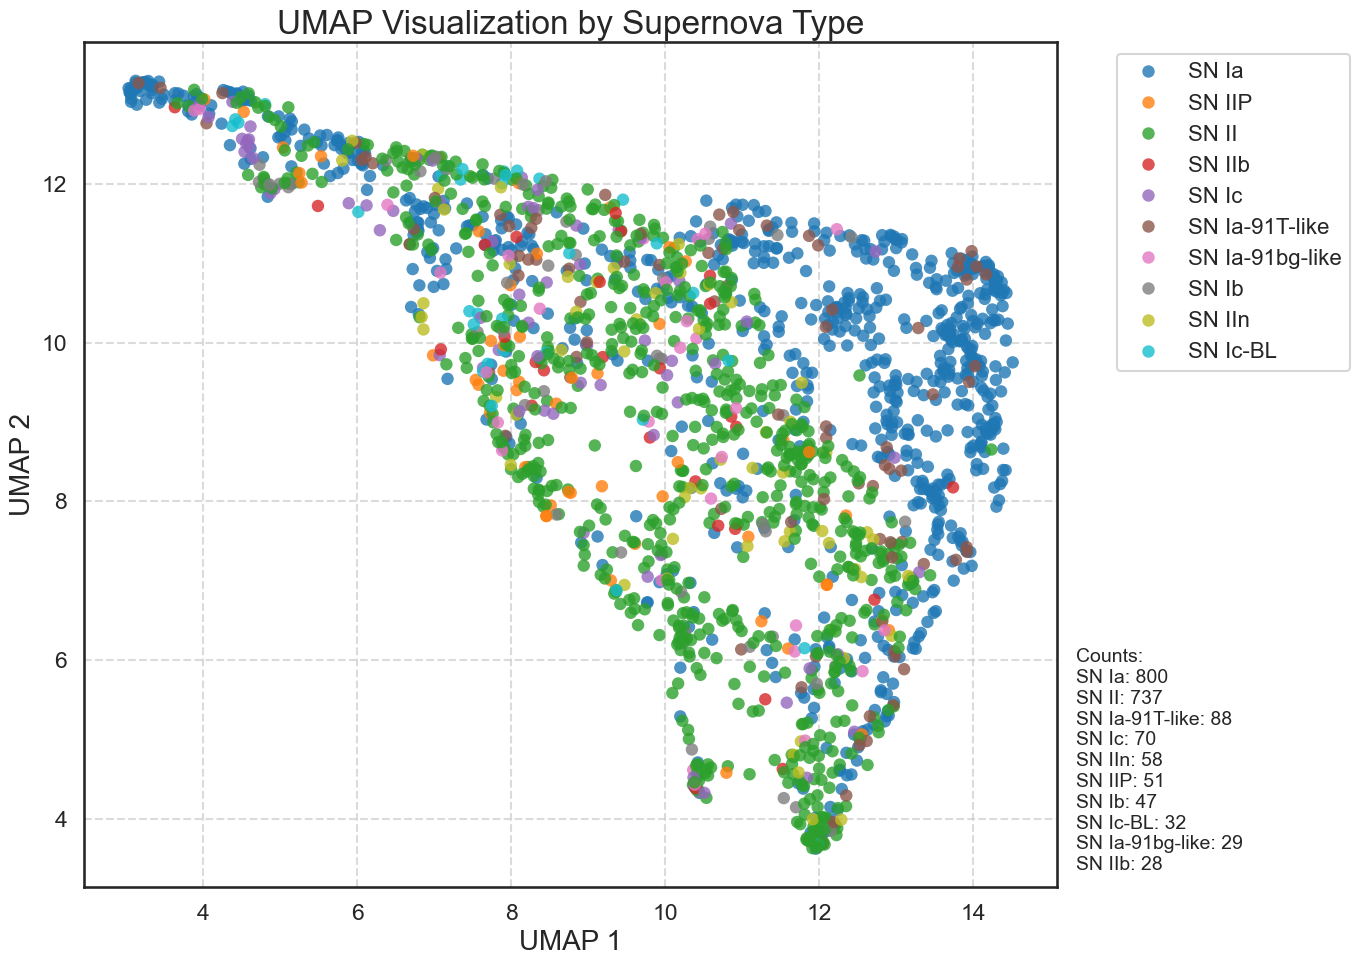

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import umap
import os

# Create output directory
output_dir = "poster_figures"
os.makedirs(output_dir, exist_ok=True)

# Load the spectra data
print("Loading data...")
spectra_data = pd.read_csv("../3. read and make single dataset/p60_spectra_for_unsupervised.csv", index_col=0)
print(f"Loaded data with shape: {spectra_data.shape}")

# Load metadata to get SN types
print("Loading metadata...")
try:
    metadata = pd.read_csv("../1. download ALL wise data/wiserep_spectra_combined.csv")
    # Extract P60 data only
    p60_metadata = metadata[metadata['Telescope'] == 'P60'].copy()
    
    # Create a mapping from object_name to SN type
    sn_type_map = {}
    for _, row in p60_metadata.iterrows():
        # Extract the object name from the ASCII file field
        ascii_file = row.get('Ascii file', '')
        if ascii_file:
            object_name = ascii_file.split('_')[0]
            sn_type = row.get('Obj. Type', 'Unknown')
            sn_type_map[object_name] = sn_type
    
    # Add SN type to our spectra data
    spectra_data['SN_Type'] = spectra_data.index.map(lambda x: sn_type_map.get(x, 'Unknown'))
    print(f"Added SN type information to {sum(spectra_data['SN_Type'] != 'Unknown')} spectra")
except Exception as e:
    print(f"Error loading metadata: {e}")
    print("Continuing without SN type information")
    spectra_data['SN_Type'] = 'Unknown'

# Preprocessing
print("Preprocessing data...")
# Convert to numpy array for model input
X = spectra_data.iloc[:, :-1].values  # Exclude SN_Type column

# Impute missing values (NaN)
print("Imputing missing values...")
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale the data
print("Scaling data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Subsample the dominant SN Ia class to improve visualization
if 'SN_Type' in spectra_data:
    # Get indices by type
    ia_indices = spectra_data[spectra_data['SN_Type'] == 'SN Ia'].index
    other_indices = spectra_data[spectra_data['SN_Type'] != 'SN Ia'].index
    
    # Subsample the SN Ia class to max 800 objects to avoid domination
    if len(ia_indices) > 800:
        print(f"Subsampling SN Ia from {len(ia_indices)} to 800 for better visualization")
        np.random.seed(42)
        ia_indices_sampled = np.random.choice(ia_indices, 800, replace=False)
        indices_to_use = np.concatenate([ia_indices_sampled, other_indices])
        
        X_balanced = X_scaled[spectra_data.index.get_indexer(indices_to_use)]
        spectra_data_balanced = spectra_data.loc[indices_to_use]
    else:
        X_balanced = X_scaled
        spectra_data_balanced = spectra_data
else:
    X_balanced = X_scaled
    spectra_data_balanced = spectra_data

# Apply UMAP with optimized parameters
print("Applying UMAP for dimensionality reduction...")
reducer = umap.UMAP(
    n_components=2,           # 2D for visualization
    n_neighbors=30,           # Higher values preserve more global structure
    min_dist=0.1,             # Lower values create tighter clusters
    metric='euclidean',
    random_state=42
)
umap_result = reducer.fit_transform(X_balanced)

Saved UMAP visualization to poster_figures/umap_by_sn_type.pdf
UMAP analysis complete!


<Figure size 1400x1000 with 0 Axes>

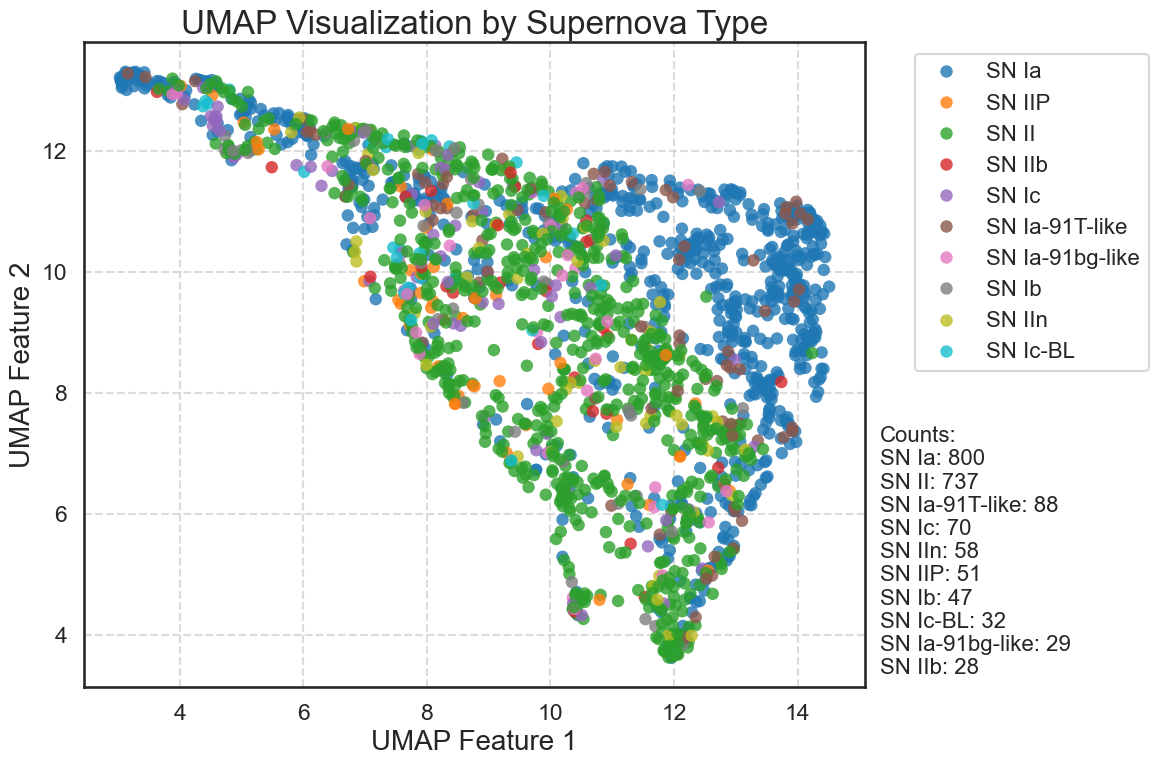

In [6]:
# Plot UMAP visualization by SN type
plt.figure(figsize=(14, 10))
if 'SN_Type' in spectra_data_balanced and sum(spectra_data_balanced['SN_Type'] != 'Unknown') > 0:
    # Get the most common SN types
    top_sn_types = spectra_data_balanced['SN_Type'].value_counts().head(10).index.tolist()
    spectra_data_filtered = spectra_data_balanced[spectra_data_balanced['SN_Type'].isin(top_sn_types)].copy()
    
    if len(spectra_data_filtered) > 0:
        umap_filtered = umap_result[spectra_data_balanced.index.get_indexer(spectra_data_filtered.index)]
        
        # Plot with enhanced aesthetics
        sns.set(style="white", context="talk")
        plt.figure(figsize=(12, 8))
        scatter = sns.scatterplot(
            x=umap_filtered[:, 0], 
            y=umap_filtered[:, 1],
            hue=spectra_data_filtered['SN_Type'],
            palette='tab10',
            alpha=0.8,
            s=80,
            edgecolor='none'
        )
        
        # Enhance the plot
        plt.title('UMAP Visualization by Supernova Type', fontsize=24)
        plt.xlabel('UMAP Feature 1', fontsize=20)
        plt.ylabel('UMAP Feature 2', fontsize=20)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
        plt.tight_layout()
        
        # Add annotation showing total counts by type
        type_counts = spectra_data_filtered['SN_Type'].value_counts()
        annotation = "Counts:\n" + "\n".join([f"{t}: {c}" for t, c in type_counts.items()])
        plt.annotate(
            annotation, 
            xy=(1.02, 0.02), 
            xycoords='axes fraction',
            fontsize=16,
            bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8)
        )
        
        plt.savefig(f"{output_dir}/umap_by_sn_type.pdf",bbox_inches='tight')
        print(f"Saved UMAP visualization to {output_dir}/umap_by_sn_type.pdf")
else:
    # Generic UMAP plot if no type information
    plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5, alpha=0.5)
    plt.title('UMAP Visualization of Supernovae Spectra')
    plt.xlabel('UMAP Feature 1')
    plt.ylabel('UMAP Feature 2')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/umap_visualization.pdf")

print("UMAP analysis complete!")

In [5]:
# plt.scatter(umap_result[:, 0], umap_result[:, 1], s=5, alpha=0.5)
# plt.title('UMAP Visualization of Supernovae Spectra')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.tight_layout()